In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import os
import datetime
import matplotlib.gridspec as gridspec
import time
import matplotlib.patheffects as PathEffects
from osgeo import gdal, osr
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#style.use('seaborn-whitegrid')
%matplotlib inline

In [4]:
binpath = '/Users/ihasan/Downloads/99_site_data/' 
fn_name = os.path.join(binpath, 'Site_ID_file_name.xlsx')
df = pd.read_excel(fn_name)

file_name = df.File_name.unique()

all_data={}

In [5]:
strt = time.time()
slno = 0
for i in file_name:
    print (i)
    skiprows = []
    if i=='Weekly Monitoring Data_24 Sites':
        skiprows = 10
    else:
        skiprows = 11
    site_list = np.array(np.where(df.File_name==i)).flat[:]
    for k in site_list:
        slno+=1
        print (slno, df.ID[k])
        fn_name = os.path.join(binpath, i+'.xlsx')
        df_d = pd.read_excel(fn_name, sheet_name=df.ID[k], skiprows=skiprows, parse_date=['YYYYMMDD'],
                        skipinitialspace=True)
        all_data[df.ID[k]]=df_d
rtime = (time.time()-strt)/60
print ('{} Minutes and {} Seconds'.format(int(rtime), np.round(((rtime-int(rtime))*60),2)))

Weekly Monitoring Data_AOSED
1 AEO-05
2 AEO-10
3 AEO-14
4 AEO-22
5 AEO-26
6 AEO-27
7 AEO-31
8 AEO-32
9 AEO-33
Weekly Monitoring Data_GMF
10 GMF-08
11 GMF-10
12 GMF-11
13 GMF-13
14 GMF-62
15 GMF-89
16 GMF-90
Weekly Monitoring Data_JJS
17 JJS-04
18 JJS-32
19 JJS-43
20 JJS-53
21 JJS-80
22 JJS-82
23 JJS-91
Weekly Monitoring Data_LoCOS
24 LoCOS-01
25 LoCOS-05
26 LoCOS-07
27 LoCOS-09
28 LoCOS-11
29 LoCOS-16
30 LoCOS-26
31 LoCOS-27
32 LoCOS-31
33 LoCOS-44
34 LoCOS-45
35 LoCOS-46
36 LoCOS-48
37 LoCOS-49
38 LoCOS-52
39 LoCOS-53
40 LoCOS-57
Weekly Monitoring Data_MF
41 MF-05
42 MF-10
43 MF-13
44 MF-16
45 MF-18
46 MF-20
47 MF-21
48 MF-30
49 MF-33
Weekly Monitoring Data_LEDARS
50 LED-16
51 LED-33
52 LED-35
53 LED-38
54 LED-39
55 LED-40
56 LED-41
57 LED-43
Weekly Monitoring Data_SHUSHILAN
58 SHU-01
59 SHU-02
60 SHU-08
61 SHU-09
62 SHU-21
63 SHU-23
64 SHU-24
65 SHU-25
66 SHU-30
67 SHU-42
68 SHU-46
69 SHU-47
70 SHU-48
71 SHU-49
72 SHU-50
73 SHU-51
74 SHU-56
75 SHU-59
Weekly Monitoring Data_24 Sites
7

In [7]:
strt = time.time()
counter=0

#plt.rc('xtick.major', size = 4)
#allbl=[]
RE_all = {}
for Site_ID in df['ID']:
    #start loop
    #Site_ID= 'MGS'
    #print(counter+1,Site_ID)
    #print (Site_ID)
    df_d = all_data[Site_ID].copy()

    infl = np.array(['Infiltration' in ks for ks in df_d.keys()[:7]])
    infl = np.array(np.where(infl==True)).flat[:]
    absn = np.array(['Abstraction' in ks for ks in df_d.keys()[:7]])
    absn = np.array(np.where(absn==True)).flat[:]

    hd1 = df_d.iloc[0]
    df_d1 = df_d.rename(columns = hd1)
    df_d2 = df_d1.drop(0)
    df_d2.set_index(df_d2['Date'], inplace=True)
    df_d2.dropna(axis=1, how='all', inplace=True)

    mt = np.array(['Meter-' in ks for ks in df_d2.keys()[:7]])
    mt = np.argwhere(mt==True).flat[:]
    mrd = {}
    for rd in mt:
        mrd['Meter-{}'.format(rd)] = df_d2.iloc[:,[0,rd]].dropna()
        mrd['Meter-{}'.format(rd)].set_index('Date', inplace=True)

        if np.size(mrd['Meter-{}'.format(rd)])!=0:
            mrd['Meter-{}'.format(rd)]['diff-{}'.format(rd)] = mrd['Meter-{}'.format(rd)].diff()
            ns = np.array(np.where(mrd['Meter-{}'.format(rd)]['diff-{}'.format(rd)]<0)).flat[:]
            mrd['Meter-{}'.format(rd)].drop(mrd['Meter-{}'.format(rd)].index[ns], inplace=True)
            #mrd['Meter-{}'.format(rd)]['t-{}'.format(rd)] = mrd['Meter-{}'.format(rd)].index.to_series(
            #).diff().dt.total_seconds().div(86400)
            #mrd['Meter-{}'.format(rd)]['rt-{}'.format(rd)] = mrd['Meter-{}'.format(rd)]['diff-{}'.format(rd)
             #                                               ]/mrd['Meter-{}'.format(rd)]['t-{}'.format(rd)]
        else:
            mrd['Meter-{}'.format(rd)]['diff-{}'.format(rd)] = 0

    di = pd.DataFrame([mrd['Meter-{}'.format(i)]['diff-{}'.format(i)]for i in mt[:absn[0]-1]]).sum()
    da = pd.DataFrame([mrd['Meter-{}'.format(i)]['diff-{}'.format(i)]for i in mt[absn[0]-1:]]).sum()
    df_d2['D.I.'] = di#[di<200]
    df_d2['D.A.'] = da#[da<200]

    DIA_f = np.array(['D.' in ks for ks in df_d2.keys()])
    DIA_f = np.array(np.where(DIA_f==True)).flat[:]

    EC_f = np.array(['EC' in ks for ks in df_d2.keys()])
    EC_f = np.array(np.where(EC_f==True)).flat[:]
    #print (df_d2)
    pn_f = np.array(['Pond' in ks for ks in df_d2.keys()[EC_f]])
    pn_f = np.array(np.where(pn_f==True)).flat[:]

    EC_fl = np.delete(EC_f, pn_f)
    #print (pn_f,EC_f, EC_fl)
    df_d2['EC_min'] =df_d2[df_d2.keys()[EC_fl]].min(axis=1)
    df_d2['EC_max'] = df_d2[df_d2.keys()[EC_f]].max(axis=1)

    df_d2['year'] = pd.to_datetime(df_d2.index, errors='coerce').year
    yrl_unfil = df_d2.groupby(['year']).sum()['D.I.'].sum()
    yrl_filt = df_d2[df_d2['EC_min']<1.54].groupby(['year']).sum()['D.A.'].sum()
    reyrl = (yrl_filt/yrl_unfil)*100
    RE_all[Site_ID]=reyrl
    counter+=1
rtime = (time.time()-strt)/60
print ('{} Minutes and {} Seconds'.format(int(rtime), np.round(((rtime-int(rtime))*60),2)))

0 Minutes and 12.57 Seconds


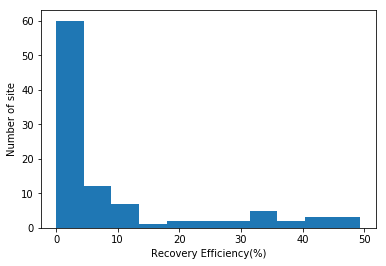

In [8]:
dta = np.array(list(RE_all.values()))
#dta = dta[dta<200]
plt.figure()
bins=plt.hist(dta[:], bins='auto') 
plt.xlabel('Recovery Efficiency(%)')
plt.ylabel('Number of site')
plt.savefig('Histogram RE', dpi=300)

In [11]:
df['RE_all'] = RE_all.values()

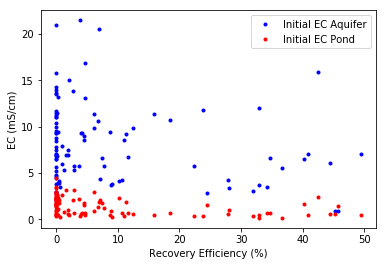

In [12]:
plt.figure()
plt.plot(df['RE_all'], df['Initial Test Well EC'], 'b.',label='Initial EC Aquifer')
plt.plot(df['RE_all'], df['Initial Pond EC'], 'r.',label='Initial EC Pond')
plt.xlabel('Recovery Efficiency (%)')
plt.ylabel(r'EC (mS/cm)')
plt.legend()
plt.savefig('RE correlation', dpi=300)

In [13]:
df['Coordinates'] = list(zip(df.Long, df.Lat))
df['Coordinates'] = df['Coordinates'].apply(Point)
sites = gpd.GeoDataFrame(df, geometry='Coordinates')

In [14]:
sdir1 = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/Bangladesh/BGD_adm/3/BGD_adm2.shp')
#sf = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/bgd_phy_forestnaturalparks_lged/bgd_phy_forestnaturalparks_lged.shp')
sf = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/natural/natural.shp')
lnus = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/landuse/landuse.shp')
lanus = gpd.read_file(lnus)
#sdir1 = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/Bangladesh/District_bnd/District_boundary_84.shp')
#sdir2 = os.path.dirname('/Users/ihasan/Downloads/Rivers of Bangladesh/BGD_cover/BGD_cov.vrt')
Bangladesh = gpd.read_file(sdir1)
fr = gpd.read_file(sf)
#cov1 = gpd.read_file(sdir2)
#std_a =  Bangladesh['NAME_2'] == ['Shatkhira', 'Khulna','Bagerhat']

In [15]:
cln = 'NAME_2'
std_a = ['Shatkhira', 'Khulna','Bagerhat', 'Jessore', 'Narail', 'Gopalgonj','Pirojpur']
#std_a = ['Shatkhira', 'Khulna','Bagerhat']
ids = np.ravel([np.where(Bangladesh[cln]==nm)[0] for nm in std_a]) 
ids = np.hstack(ids)

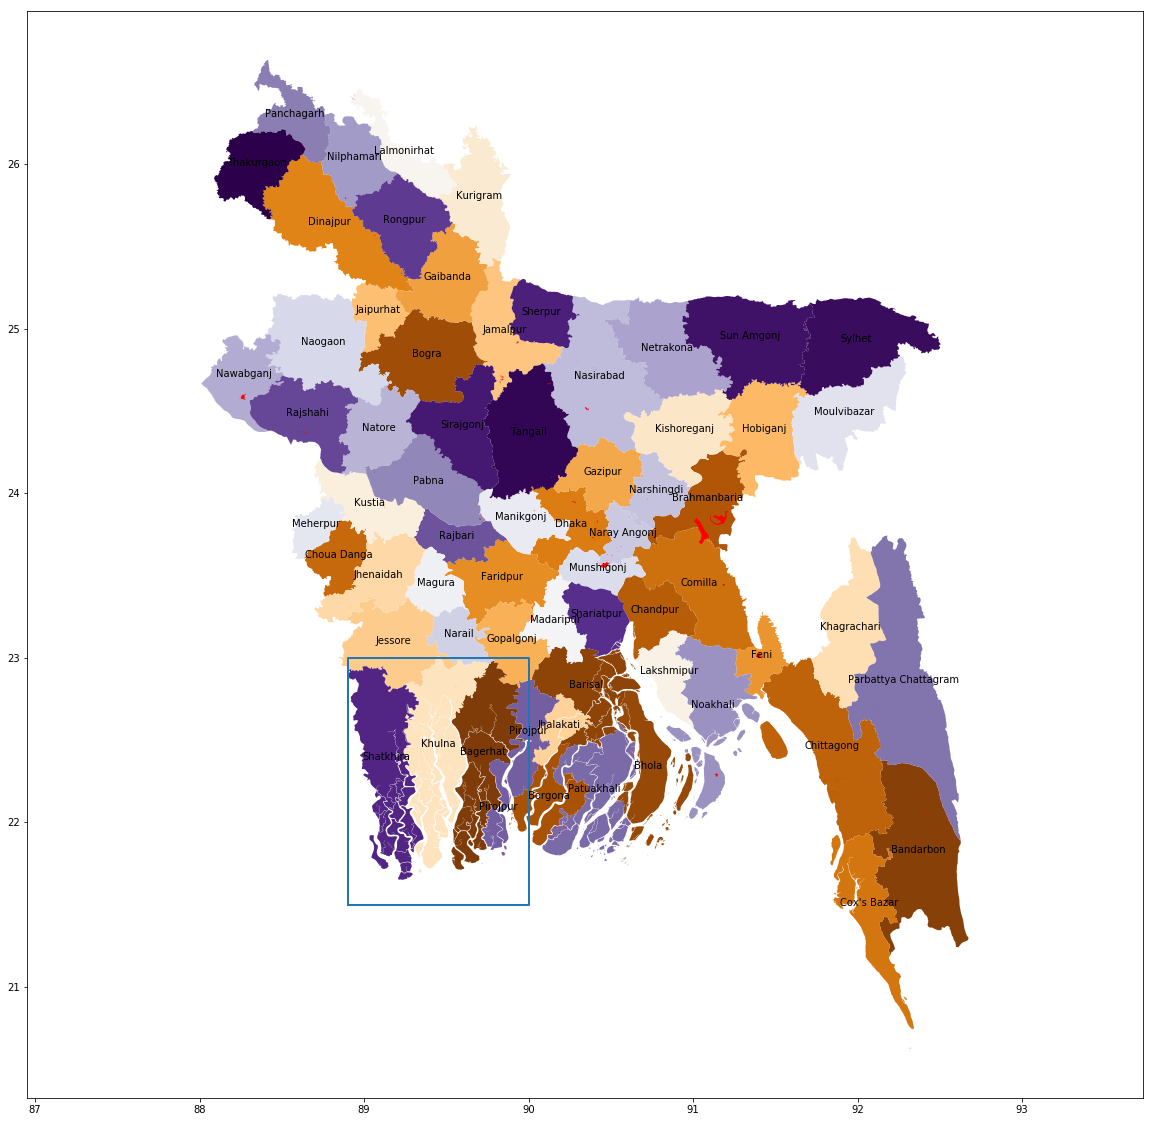

In [16]:
ax=Bangladesh.plot(figsize=(20,20),column=cln, cmap='PuOr')
ax.axis('equal')
for idx, row in Bangladesh.iterrows():
    fnt = 10
    plt.annotate(s=row[cln], xy=(Bangladesh.geometry.centroid.x[idx],Bangladesh.geometry.centroid.y[idx]),
                 horizontalalignment='center', fontsize=fnt, wrap=True)
lanus.plot(ax=ax, color='r')
plt.plot([88.9, 90, 90, 88.9, 88.9],[21.5, 21.5, 23, 23,21.5], lw=2)
#fr[fr['type']=='forest'].plot(ax=ax)
std_a=['Shatkhira', 'Bagerhat', 'Khulna']

/Users/ihasan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


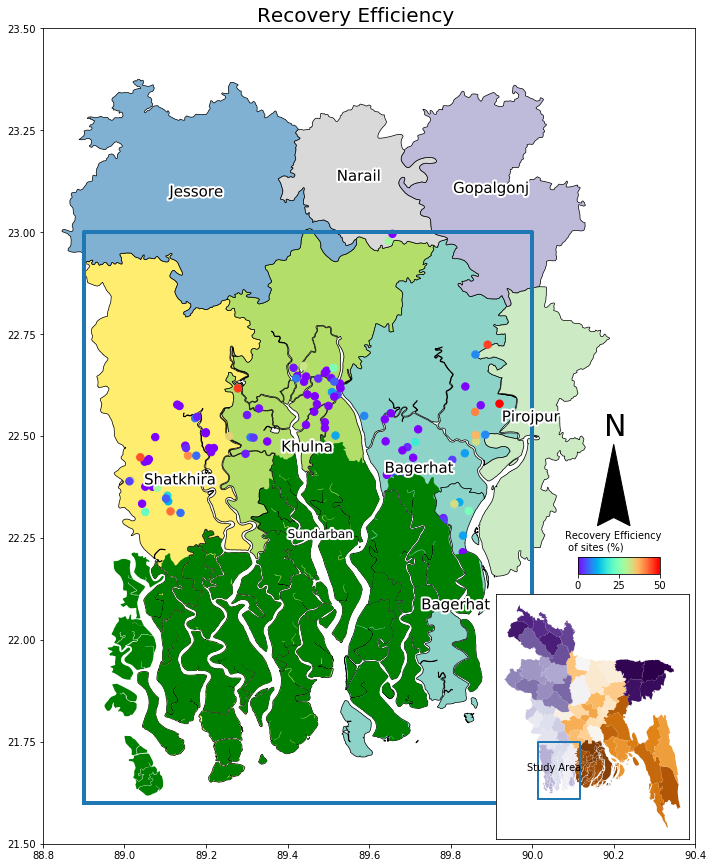

In [17]:
#fig=plt.figure()

studyar = Bangladesh.iloc[ids,:]
studyar.iloc[7,6]='Bagerhat'
std_a1=studyar.plot(figsize=(15,15),column=cln, cmap='Set3', edgecolor='k', lw=0.7)
plt.suptitle('Recovery Efficiency',x=0.5, y=0.9, fontsize=20)
plt.text(x=90.08, y=22.22, s='Recovery Efficiency \n of sites (%)', fontsize=9.8)
tx1 = plt.text(x=89.4, y=22.25, s='Sundarban', fontsize=12)
tx1.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
plt.text(x=90.2-0.025, y=22.5, s='N', fontsize=30)
plt.arrow(90.2, 22.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')
plt.plot([88.9, 90, 90, 88.9, 88.9],[21.6, 21.6, 23, 23,21.6], lw=4)
for idx, row in studyar.iterrows():
    fnt = 10
    txt=plt.annotate(s=row[cln], xy=(studyar.geometry.centroid.x[idx],studyar.geometry.centroid.y[idx]),
                 horizontalalignment='center', fontsize=15, wrap=True, color='k')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
#std_a1.axis('equal')
plt.xlim(88.8, 90.4)
plt.ylim(21.5, 23.5)
a=inset_axes(std_a1, width="30%", height='30%',loc='lower right')
Bangladesh.plot(figsize=(20,20), cmap='PuOr',ax=a)
plt.text(x=88.6, y=22.25, s='Study Area', fontsize=9.8)
plt.plot([88.9, 90, 90, 88.9, 88.9],[21.5, 21.5, 23, 23,21.5], lw=2)
plt.xticks([])
plt.yticks([])

csm = sites.plot(ax=std_a1, column='RE_all', cmap='rainbow', markersize=55)
fr[fr['type']=='forest'].plot(ax=std_a1, color='g')
sm = plt.cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=df['RE_all'].min(), vmax=50))
sm._A = []
#divider = make_axes_locatable(std_a1)
#cax = divider.append_axes("center", size="5%", pad=0.05)
#cbar_axis = inset_axes(std_a1, width="10%", height='2%',loc='center right')
cbar_axis = inset_axes(std_a1, width='10%', height='5%',loc='lower left',
                       bbox_to_anchor=[90.1, 22.15, 2, 0.8],bbox_transform=std_a1.transData)
#cbar_axis = fig.add_axes([0.8, 0.2, 0.3, 0.2])
cbar = plt.colorbar(sm, cax=cbar_axis, orientation='horizontal', pad=0.02)
plt.savefig('/Users/ihasan/Downloads/99_site_data/report/RE_map.png', dpi=300);